## IMPORT DEPENDENCIES

In [2]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## Set GPU Growth

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## Create Folder Structures

In [7]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')
TEST_PATH = os.path.join('data', 'test_folder')

In [8]:
# Creating Directory
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

## Untar Lablelled Faces in the wild Dataset

In [86]:
# # Uncompress Tar GZ Labelled Faces in the wild Dataset
!tar -xf lfw.tgz

In [87]:
# @title Default title text
# Move LFW images to data/negative
for directory in os.listdir('lfw'):
    dir_path = os.path.join('lfw', directory)
    if os.path.isdir(dir_path):
        for file in os.listdir(dir_path):
            EX_PATH  = os.path.join(dir_path, file)
            NEW_PATH = os.path.join(NEG_PATH, file)
            os.replace(EX_PATH, NEW_PATH)

## Collect Positive and Anchor Classes

In [9]:
# Import uuid library to generate unique image names
import uuid

In [10]:
uuid.uuid1()

UUID('a9f9cb2a-5bd4-11f0-9647-50e0854bb562')

In [259]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    # cut down frame to 250x250px
    frame = frame[280:280+250, 450:450+250, :]

    #flipping horizontally in camera feed
    frame =cv2.flip(frame,1,1)

    # Collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)


    # Collect possitive
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out Positive image
        cv2.imwrite(imgname, frame)

    # Show image back to screen
    cv2.imshow('Image Collection', frame)

    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break

# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

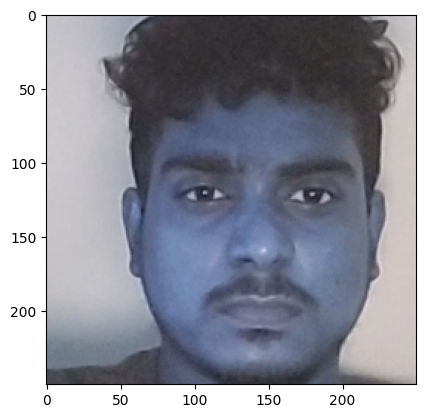

In [260]:
plt.imshow(frame)

In [11]:
def data_aug(img):
    data = []
    for i in range(9):
        # Start from the original image for each augmentation
        aug = tf.identity(img)

        # Apply random augmentations with new seeds
        aug = tf.image.stateless_random_brightness(aug, max_delta=0.02, seed=(i, 1))
        aug = tf.image.stateless_random_contrast(aug, lower=0.6, upper=1, seed=(i, 2))
        aug = tf.image.stateless_random_flip_left_right(aug, seed=(i, 3))
        aug = tf.image.stateless_random_jpeg_quality(aug, min_jpeg_quality=90, max_jpeg_quality=100, seed=(i, 4))
        aug = tf.image.stateless_random_saturation(aug, lower=0.9, upper=1, seed=(i, 5))

        data.append(aug)

    return data

In [12]:
# for file_name in os.listdir(os.path.join(TEST_PATH)):
#     img_path = os.path.join(TEST_PATH, file_name)
#     img = cv2.imread(img_path)

#     if img is not None:
#         img_tensor = tf.convert_to_tensor(img, dtype=tf.uint8)
#         augmented_images = data_aug(img_tensor)

#         for image in augmented_images:
#             cv2.imwrite(os.path.join(TEST_PATH, f"{uuid.uuid1()}.jpg"), image.numpy())

In [13]:
# img_path = os.path.join(ANC_PATH, '0e63abf7-5974-11f0-9140-50e0854bb562.jpg')
# img = cv2.imread(img_path)
# augmented_images = data_aug(img)

# for image in augmented_images:
#     cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [92]:
for file_name in os.listdir(os.path.join(ANC_PATH)):
    img_path = os.path.join(ANC_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug_v2(img)

    for image in augmented_images:
        cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [93]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug_v2(img)

    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [14]:
anchor   = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(3000)

In [15]:
dir_test = anchor.as_numpy_iterator()

## Preprocessing - Scale and Resize

In [16]:
def preprocess(file_path):

    # Step 1: Read the image file as a byte string
    byte_img = tf.io.read_file(file_path)
    
     # Step 2: Decode the byte string into a JPEG image tensor
    img      = tf.io.decode_jpeg(byte_img)

    # Step 3: Resize the image to a fixed size of 100x100 with 3 color channels (RGB)
    img      = tf.image.resize(img, (100, 100))
    
    # Step 4: Normalize the image pixel values to the range [0, 1]
    img      = img / 255.0

    # Step 5: Return the preprocessed image tensor
    return img

In [17]:
img = preprocess('data\\anchor\\6e593ba2-5973-11f0-bffc-50e0854bb562.jpg')

In [18]:
img.numpy().max()

0.9009804

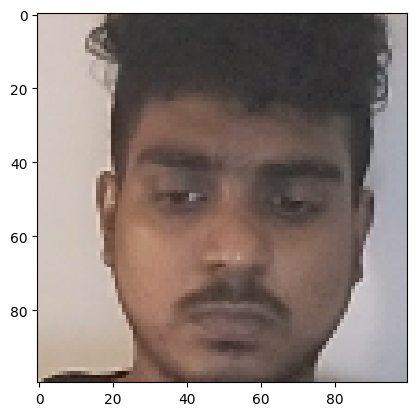

In [19]:
plt.imshow(img)

## Create Labelled Dataset

In [20]:
# (Anchor Images, positive - (similar) images) => 1,1,1,1
# (anchor, negative - (dissimilar) images) => 0,0,0,0

In [21]:
# Create a dataset of positive pairs (anchor, positive) with label 1
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))

# Create a dataset of negative pairs (anchor, negative) with label 0
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))

# Combine both positive and negative datasets into one
data      = positives.concatenate(negatives)

In [29]:
samples = data.as_numpy_iterator()

In [30]:
example = samples.next()

In [31]:
example

(b'data\\anchor\\deb87ec4-5a42-11f0-94e1-50e0854bb562.jpg',
 b'data\\positive\\fd3cbcc5-5a42-11f0-b912-50e0854bb562.jpg',
 1.0)

## Build train and test partition

In [32]:
# Function to preprocess a pair of images (anchor and comparison) along with their label

def preprocess_twin(input_img, validation_img, label):

    # Apply the same preprocessing steps to both input (anchor) and validation (positive/negative) images
    return(preprocess(input_img), preprocess(validation_img), label)

In [33]:
res = preprocess_twin(*example)

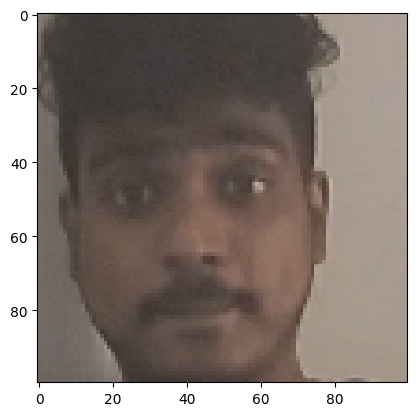

In [34]:
plt.imshow(res[0])

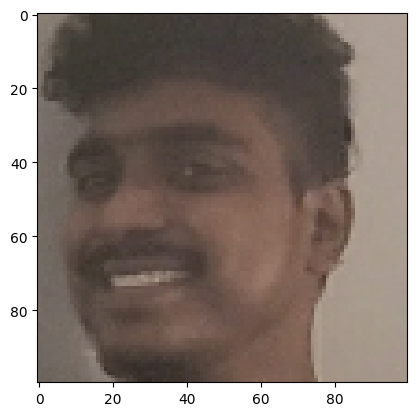

In [35]:
plt.imshow(res[1])

In [36]:
res[1]

<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[0.5480392 , 0.5009804 , 0.45392156],
        [0.54901963, 0.5019608 , 0.45490196],
        [0.54019606, 0.4990196 , 0.45196077],
        ...,
        [0.6784314 , 0.6284314 , 0.5901961 ],
        [0.68014705, 0.63308823, 0.5860294 ],
        [0.68235296, 0.63529414, 0.5882353 ]],

       [[0.5441176 , 0.4970588 , 0.45      ],
        [0.54240197, 0.4987745 , 0.45171568],
        [0.5411765 , 0.5019608 , 0.45637256],
        ...,
        [0.67941177, 0.62941176, 0.59117645],
        [0.67769605, 0.6306372 , 0.5835784 ],
        [0.67745095, 0.63039213, 0.5833333 ]],

       [[0.5382353 , 0.4970588 , 0.45588234],
        [0.5357843 , 0.49656862, 0.45539215],
        [0.53431374, 0.49509802, 0.45539215],
        ...,
        [0.6784314 , 0.6306372 , 0.5857843 ],
        [0.67769605, 0.6306372 , 0.5835784 ],
        [0.6745098 , 0.627451  , 0.5803922 ]],

       ...,

       [[0.43308824, 0.40563726, 0.3762255 ],
        [0.42

In [37]:
# Build dataloader pipeline

# Apply the preprocess_twin function to each (anchor, other_img, label) tuple in the dataset
data = data.map(preprocess_twin)

# Cache the dataset in memory for faster subsequent epochs (avoids reprocessing)
data = data.cache()

# Shuffle the dataset to randomize the order of the pairs, improving model generalization
data = data.shuffle(buffer_size = 10000)

In [38]:
data

<_ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [39]:
round(len(data)*.7) # Size of training datasets i.e 70 percent of total size(6000)

4200

## Training partition 

In [40]:
# Take 70% of the dataset for training
train_data = data.take(round(len(data)*.7))

# Batch the training data into groups of 16 samples
train_data = train_data.batch(16)

# Prefetch 8 batches to optimize performance and reduce data loading bottlenecks
train_data = train_data.prefetch(8)

In [41]:
train_samples = train_data.as_numpy_iterator()

In [42]:
train_sample = train_samples.next()

In [43]:
len(train_sample[0])

16

In [44]:
round(len(data)*.3) # Test partition size i.e 30 percent of total size(6000)

1800

## Testing partition

In [45]:
# Skip the first 70% of the dataset (used for training)
test_data = data.skip(round(len(data)*.7))

# Take the next 30% of the dataset (used for testing)
test_data = test_data.take(round(len(data)*.3))

# Batch the testing data into groups of 16 samples
test_data = test_data.batch(16)

# Prefetch 8 batches to speed up data loading during evaluation
test_data = test_data.prefetch(8)

## Build Embedding Layer

In [46]:
def make_embedding():

    # Define input layer for an image of shape 100x100x3 (RGB)
    inp = Input(shape=(100, 100, 3), name='input_image')

    # # Block 1: Convolution + Max Pooling
    c1 = Conv2D(64, (10, 10), activation='relu')(inp)                 # Large receptive field for initial feature extraction
    m1 = MaxPooling2D(pool_size=(2, 2), padding='same')(c1)           # Downsample feature map

    # Block 2: Convolution + Max Pooling
    c2 = Conv2D(128, (7, 7), activation='relu')(m1)                   # Deeper features
    m2 = MaxPooling2D(pool_size=(2, 2), padding='same')(c2)

    # Block 3: Convolution + Max Pooling
    c3 = Conv2D(128, (4, 4), activation='relu')(m2)                   # More refined patterns
    m3 = MaxPooling2D(pool_size=(2, 2), padding='same')(c3)

    # Block 4: Final Convolution layer
    c4 = Conv2D(256, (4, 4), activation='relu')(m3)                   # Final high-level features

    # Flatten and Dense layer to produce final embedding vector
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)                        # Final 4096-dim embeddingor 'relu' if you want   

    
    # Build and return the model
    return Model(inputs=inp, outputs=d1, name='embedding')

In [47]:
embedding = make_embedding()

In [48]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

## L1 Distance Layer

In [49]:
# Define a custom layer to compute L1 (Manhattan) distance between two embeddings

class L1Dist(Layer):

    # Constructor method - allows passing additional arguments to the base Layer class
    def __init__(self, **kwargs):
        super().__init__()

    # This method defines what happens when the layer is called (forward pass)
    def call(self, input_embedding, validation_embedding):
         # Compute the element-wise absolute difference (L1 distance)
        return tf.math.abs(input_embedding - validation_embedding)

In [50]:
l1 = L1Dist()

In [51]:
l1

## Make Siamese Model

In [52]:
def make_siamese_model():

     # Anchor image input (first image in the pair)
    input_image      = Input(name='input_img', shape=(100, 100, 3))

     # Validation image input (second image in the pair)
    validation_image = Input(name= 'validation_img', shape=(100, 100, 3))

    # Instantiate the L1 distance layer (used to compute similarity between embeddings)
    siamese_layer       = L1Dist()
    siamese_layer._name = 'distance'

    # Get embeddings for both input and validation images
    distances           = siamese_layer(embedding(input_image), embedding(validation_image))

    # Final classification layer: predicts similarity (1 = same, 0 = different)
    classifier = Dense(1, activation='sigmoid')(distances)

    
    # Define the Siamese model with two inputs and one output
    return Model(inputs = [input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [53]:
input_image      = Input(name='input_img', shape=(100, 100, 3))

In [54]:
validation_image = Input(name= 'validation_img', shape=(100, 100, 3))

In [55]:
embedding(input_image)

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'embedding')>

In [56]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [57]:
siamese_layer       = L1Dist()

In [58]:
distances = siamese_layer(inp_embedding, val_embedding)

In [59]:
classifier = Dense(1, activation='sigmoid')(distances)

In [60]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_1')>

In [61]:
siamese_network = Model(inputs = [input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [62]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [63]:
siamese_model = make_siamese_model() # Initializeing model

In [64]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

## Setup Loss and Optimizer

In [65]:
# Define binary cross-entropy loss function
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [66]:
# Define the optimizer for training the model
opt = tf.keras.optimizers.Adam(1e-4)      # Adam optimizer with a learning rate of 0.0001

## Build Train Step Function

In [67]:
# Convert the training dataset into a NumPy-style iterator
# This allows you to manually fetch batches using .next() for debugging or visualization

test_batch = train_data.as_numpy_iterator()

In [68]:
# Retrieve the next batch of data from the NumPy iterator
batch_1 = test_batch.next()

In [69]:
# Extract the first two elements (anchor and validation images) from the batch

X = batch_1[:2]

In [70]:
# Extract the labels (similar = 1, dissimilar = 0) from the batch

y = batch_1[2]

In [71]:
y

array([1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0.],
      dtype=float32)

## Training step function

In [72]:
# Define a TensorFlow graph-compiled training step function

@tf.function
def train_step(batch):

    # Record operations for automatic differentiation
    with tf.GradientTape() as tape:

        # Extract the anchor and validation images from the batch
        X = batch[:2]      # X = (anchor_images, validation_images)

        # Extract the labels (1 for similar, 0 for dissimilar)
        y = batch[2]

        # Forward pass: get model predictions
        yhat = siamese_model(X, training=True)
        
        # Compute binary cross-entropy loss between true and predicted labels
        loss = binary_cross_loss(y, yhat)

    # Print the loss (for debugging; note: prints only in eager mode, not when traced)    
    print(loss)

    # Compute gradients of the loss with respect to model weights
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Apply the gradients to update the model's weights using the optimizer
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))


    return loss

## Build Training Loop

In [73]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [74]:
def train(data, EPOCHS):
    # Loop through all epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))

        # Initialize progress bar
        progbar = tf.keras.utils.Progbar(len(data))

        # Create metric objects to track performance
        r = Recall()
        p = Precision()

        # Loop through each batch in the training dataset
        for idx, batch in enumerate(data):
            # Run one training step (forward + backprop)
            loss = train_step(batch)
            
            # Get model predictions for the batch (used for metric updates)
            yhat = siamese_model.predict(batch[:2])     # batch[:2] = (anchor, validation)

            # Update recall and precision metrics
            r.update_state(batch[2], yhat)   # batch[2] = true labels
            p.update_state(batch[2], yhat)

            # Update the progress bar
            progbar.update(idx+1)

        # Print final loss, recall, and precision for the epoch
        print(loss.numpy(), r.result().numpy(), p.result().numpy())

## Train the Model

In [75]:
EPOCHS = 6

In [187]:
train(train_data, EPOCHS)


 Epoch 1/6
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
1/1 [==============================] - 0s 240ms/step
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
263/263 [==============================] - 374s 1s/step
0.038162574 0.92458236 0.9923156

 Epoch 2/6
263/263 [==============================] - 394s 1s/step
0.0006383576 0.9951923 0.9980714

 Epoch 3/6
263/263 [==============================] - 388s 1s/step
0.03864657 0.99385345 0.9985748

 Epoch 4/6
263/263 [==============================] - 396s 2s/step
0.00028700219 0.9985748 0.9985748

 Epoch 5/6
263/263 [==============================] - 382s 1s/step
0.027693434 0.99904305 0.99856526

 Epoch 6/6
263/263 [==============================] - 389s 1s/step
0.007222766 0.99759614 0.99759614


## Evaluate Model

In [76]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [58]:
# Fetch the next batch from the test dataset as NumPy arrays

test_var = test_data.as_numpy_iterator().next()

In [78]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 0s 420ms/step


array([[9.9381429e-01],
       [9.9999756e-01],
       [9.9948603e-01],
       [5.5760196e-05],
       [2.1921765e-07],
       [2.1439777e-07],
       [1.7598384e-07],
       [2.8846850e-06],
       [9.9827832e-01],
       [9.9601978e-01],
       [1.7728462e-07],
       [9.9149758e-01],
       [9.9999541e-01],
       [9.9987376e-01],
       [9.9649423e-01],
       [1.0087644e-07]], dtype=float32)

In [79]:
# Post processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0]

In [80]:
y_true

array([1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0.],
      dtype=float32)

In [81]:
# Creating a Recall object
m = Recall()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [82]:
# Creating a precision object
p = Precision()

# Calculating the recall value
p.update_state(y_true, y_hat)

# Return Recall Result
p.result().numpy()

1.0

In [83]:
# Initialize Recall and Precision metric objects
r = Recall()
p = Precision()

# Loop over test dataset batches using a NumPy iterator
for test_input, test_val, y_true in test_data.as_numpy_iterator():

    # Predict similarity scores using the Siamese model
    yhat = siamese_model.predict([test_input, test_val])

    # Update recall and precision metrics based on predictions
    r.update_state(y_true, yhat)
    p.update_state(y_true, yhat)

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 0s 176ms/step
0.99666667 0.9988864


## Visualize results

In [84]:
y_true

array([1., 1., 1., 1., 0., 0., 1., 1.], dtype=float32)

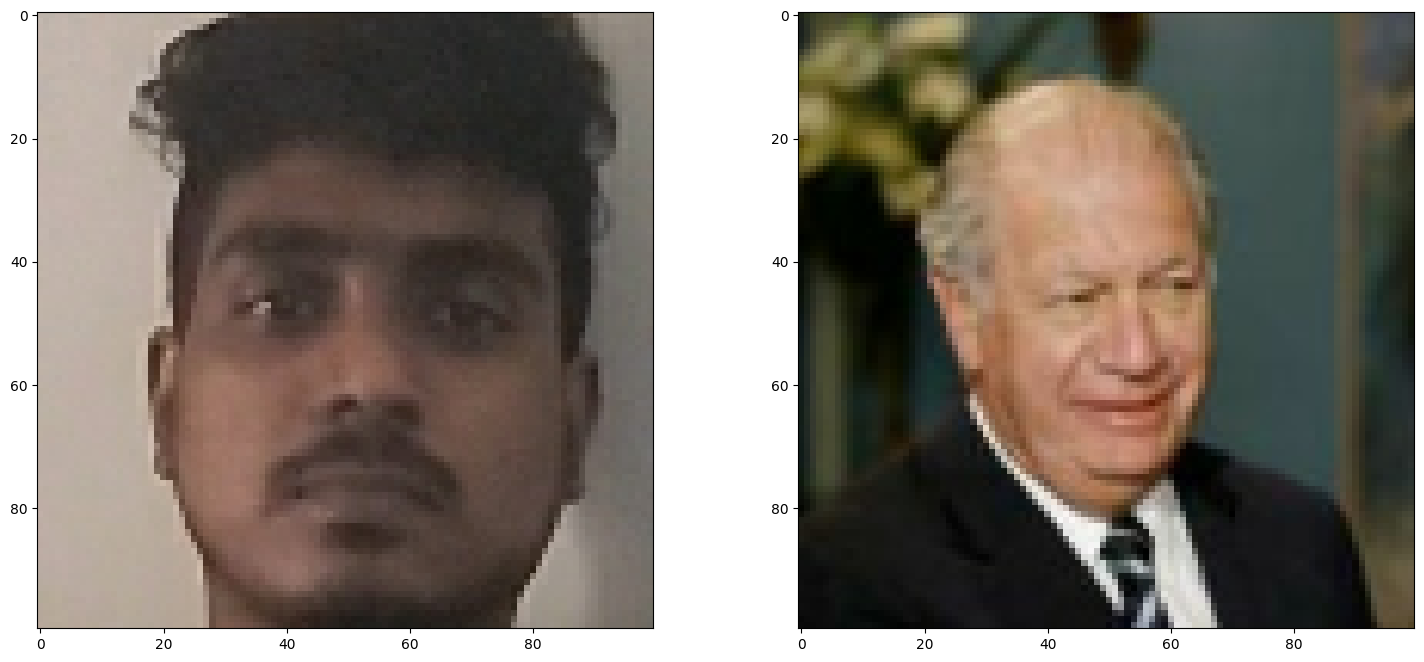

In [87]:
i = 5
plt.figure(figsize=(18, 8))
plt.subplot(1,2,1)
plt.imshow(test_input[i])
plt.subplot(1,2,2)
plt.imshow(test_val[i])
plt.show()

## Save Model

In [69]:
# siamese_model.save('siamesemodelv2.h5')

In [168]:
# Reload model
model = tf.keras.models.load_model('siamesemodelv2.h5',
                                   custom_objects={'L1Dist':L1Dist,
                                                   'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [89]:
# Make predictions with reloaded model
model.predict([test_input, test_val])

1/1 [==============================] - 0s 229ms/step


array([[9.4238132e-01],
       [9.5541966e-01],
       [9.9669665e-01],
       [9.9992353e-01],
       [1.7598384e-07],
       [6.2180825e-06],
       [9.9989748e-01],
       [8.4994572e-01]], dtype=float32)

In [90]:
[1 if prediction > 0.5 else 0 for prediction in siamese_model.predict([test_input, test_val])]

1/1 [==============================] - 0s 124ms/step


[1, 1, 1, 1, 0, 0, 1, 1]

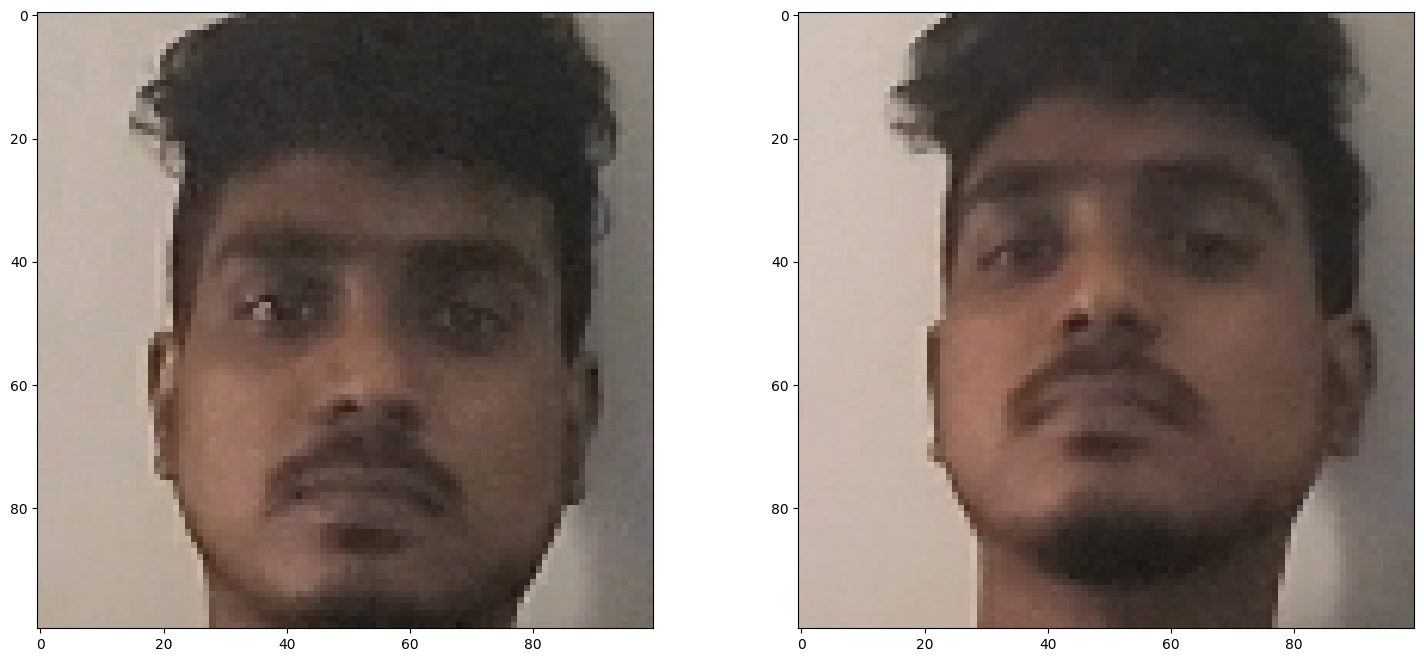

In [92]:
i = 1
plt.figure(figsize=(18, 8))
plt.subplot(1,2,1)
plt.imshow(test_input[i])
plt.subplot(1,2,2)
plt.imshow(test_val[i])
plt.show()

In [93]:
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

## Verification Function

In [94]:
# To check whether input image has face or not

def has_face(image_path):
    # Load image using OpenCV
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Image not found or unreadable: {image_path}")
        return False

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Load Haar cascade classifier for face detection
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

    # Return True if at least one face is found
    return len(faces) > 0

In [95]:
# Verification function to recognize face in the input image

def verify(model, detection_threshold, verification_threshold):
    results = []    # To store similarity scores between input and verification images

     # Loop through each image in the verification folder
    for image in os.listdir(os.path.join('application_data', 'verification_images')):

        # Define paths for input and current verification image
        input_img_path = os.path.join('application_data', 'input_image', 'input_image.jpg')
        verification_img_path = os.path.join('application_data', 'verification_images', image)
        
        # Optional safety check: skip verification if no face is found in input image
        if has_face(input_img_path) is False:
            print("No face found in input image")
            return [], False

        # Preprocess both input and verification images    
        input_img = preprocess(input_img_path)
        verification_img = preprocess(verification_img_path)

        # Predict similarity score using the Siamese model
        result = model.predict(list(np.expand_dims([input_img, verification_img], axis=1)))
        results.append(result)

    # Count how many predictions exceed the detection threshold
    detection = np.sum(np.array(results) > detection_threshold)

    # Compute verification score as percentage of positive detections
    verification = detection / len(results)

    # Final verification decision: True if score exceeds verification threshold
    verified = verification > verification_threshold

    # Print details
    print(detection, verification)

    # Return individual results and final decision
    return results, verified

In [96]:
# def display_results(inp_img):
#     frame_rgb = cv2.cvtColor(inp_img, cv2.COLOR_BGR2RGB)  # Convert to RGB

#     plt.imshow(frame_rgb)
#     plt.axis('off')  # Optional: hides axes
#     plt.show()
    

In [166]:
def display_results(input_images, verification_results, images_per_row=4):
    num_images = len(input_images)
    cols = images_per_row
    rows = (num_images + cols - 1) // cols  # Ceiling division

    plt.figure(figsize=(cols * 3, rows * 3))  # Width x Height in inches

    for idx, (frame, verification_result) in enumerate(zip(input_images, verification_results)):
        # Convert BGR to RGB for correct color display (if using OpenCV)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Dynamically place in subplot grid
        plt.subplot(rows, cols, idx + 1)
        plt.imshow(frame_rgb)
        plt.title(f"Verified: {bool(verification_result)}", fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

## OpenCV Real Time Verification

In [192]:
cap = cv2.VideoCapture(0)
input_images = []
results_list = []
while cap.isOpened():
    ret, frame = cap.read()

     # cut down frame to 250x250px
    frame = frame[280:280+250, 450:450+250, :]
    
    #flipping horizontally in camera feed
    frame =cv2.flip(frame,1,1)
    
    cv2.imshow('Verification', frame)

    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder
        input_images.append(frame)
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)

        # Run Verification
        results, verified = verify(model, 0.8, 0.6)   
        results_list.append(verified)
        print(verified)
        
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 55ms/step
79 0.79
True
1/1 [==============================] - 0s 67ms/step
74 0.74
True
1/1 [==============================] - 0s 57ms/step
39 0.39
False
1/1 [==============================] - 0s 62ms/step
23 0.23
False
No face found in input image: application_data\input_image\input_image.jpg
False
No face found in input image: application_data\input_image\input_image.jpg
False
1/1 [==============================] - 0s 57ms/step
36 0.36
False
1/1 [==============================] - 0s 58ms/step
18 0.18
False


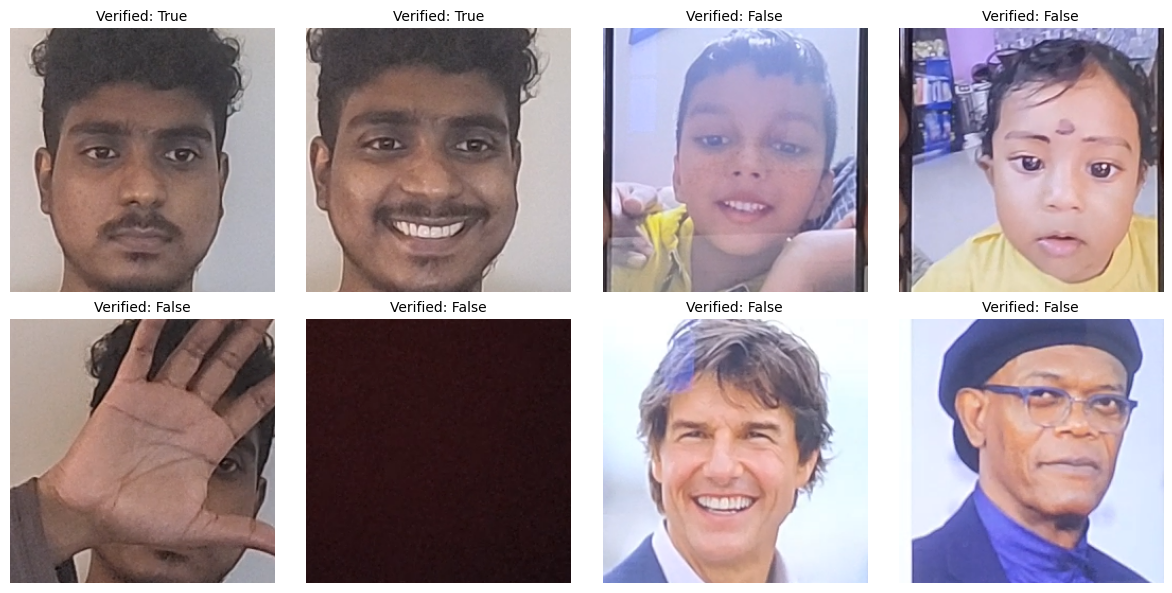

In [193]:
display_results(input_images, results_list)